In [1]:
include("BayesianTensorFac.jl")
include("SynthControlIG.jl")

updateGibbs! (generic function with 2 methods)

## California

In [2]:
data = load("smoking.rda")["smoking"]
numStates = 39
numYears = 31
# California is state 3 and the intervention happened in 1989
A = 2
T = numYears
I = numStates
obsT = 19

X = zeros(I-1, T)
Y = zeros(T)
for row ∈ eachrow(data)
    if row["state"] == 3
        Y[Int64(row["year"] - 1969.0)] = row["cigsale"] 
    elseif row["state"] < 3
        X[Int64(row["state"]), Int64(row["year"] - 1969.0)] = row["cigsale"] 
    elseif row["state"] > 3
        X[Int64(row["state"])-1, Int64(row["year"] - 1969.0)] = row["cigsale"] 
    end
end

YObs = zeros(A, I, T)
for row ∈ eachrow(data)
    if row["state"] == 3 && Int64(row["year"]) > 1988
        YObs[2, Int64(row["state"]), Int64(row["year"] - 1969.0)] = row["cigsale"] 
    else
        YObs[1, Int64(row["state"]), Int64(row["year"] - 1969.0)] = row["cigsale"] 
    end
end

mask = Set{Tuple{Int64, Int64, Int64}}()

for a ∈ 1:A
    for i ∈ 1:I
        for t ∈ 1:T
            if YObs[a,i,t] == 0.0
                push!(mask, (a, i, t))
            end
        end
    end
end

In [3]:
numItr = 10000

α = 1/(I-1.0) .* ones(I-1)
θ = 1.0
β = 1.0

synth = initGibbs(I-1, obsT, θ, β, α)

samplePrior!(synth)

synth.Y = deepcopy(Y[1:obsT])
synth.X = deepcopy(X[:, 1:obsT])

sampleC = zeros(numItr)
sampleD = zeros(numItr, I-1)
Ysamples = zeros(numItr, T)

@showprogress for i ∈ 1:numItr
    updateGibbs!(synth)
end

thin = 1

@showprogress for i ∈ 1:numItr*thin
    updateGibbs!(synth)
    if i % thin == 0
        sampleC[div(i,thin)] = deepcopy(synth.C)
        sampleD[div(i,thin), :] = deepcopy(synth.D)
        Ysamples[div(i,thin), :] = sampleY(synth, X, T)
    end
end

predY = mean(Ysamples, dims=1)'
errUpSynth = zeros(T)
errDownSynth = zeros(T)
for t ∈ 1:T
    errUpSynth[t] = quantile(Ysamples[:, t], 0.75)
    errDownSynth[t] =  quantile(Ysamples[:, t], 0.25)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [4]:
numItr = 10000
K = 1
σ = 1.0

tensorFac = initGibbs(A, I, T, K, σ, σ, σ, σ)

samplePrior!(tensorFac)
tensorFac.Y = deepcopy(YObs)

Ysamples = zeros(numItr, A, I, T)

@showprogress for i ∈ 1:numItr
    updateGibbs!(tensorFac, mask)
end

@showprogress for i ∈ 1:numItr
    updateGibbs!(tensorFac, mask)
    Ysamples[i, :, :, :] = deepcopy(tensorFac.Y)
end

tensorPred = mean(Ysamples[:, 1, 3, :], dims=1)'
errUpTensor = zeros(T)
errDownTensor = zeros(T)
for t ∈ 1:T
    errUpTensor[t] = quantile(Ysamples[:, 1, 3, t], 0.75)
    errDownTensor[t] = quantile(Ysamples[:, 1, 3, t], 0.25)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:40
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39


In [5]:
df = load_smoking()
panel = load_smoking_panel()
s = SimpleSCM(panel)
SynthControl.fit!(s)


Synthetic Control Model

Treatment panel:
	Model is fitted
	Impact estimates: [-8.44, -9.207, -12.633, -13.727, -17.531, -22.047, -22.857, -23.996, -26.258, -23.341, -27.522, -26.598]


Balanced Panel - single treated unit, continuous treatment
    Treated unit: 3
    Number of untreated units: 38
    First treatment period: 1989
    Number of pretreatment periods: 19
    Number of treatment periods: 12


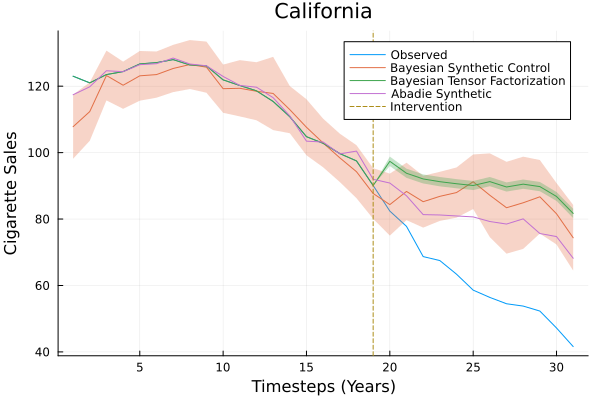

"C:\\Users\\nihar\\OneDrive\\Documents\\GitHub\\AppliedCausality\\California.png"

In [6]:
plot(Y, label="Observed")

plot!(predY, ribbon=errUpSynth - errDownSynth, fillalpha=.3, label="Bayesian Synthetic Control")
plot!(tensorPred, ribbon=errUpTensor - errDownTensor, fillalpha=.3, label="Bayesian Tensor Factorization")
plot!(s.ŷ₁, label="Abadie Synthetic")

plot!([19], label="Intervention", seriestype = :vline, line=:dash)
display(title!("California", xlabel="Timesteps (Years)", ylabel="Cigarette Sales"))
savefig("California.png")

## Basque

In [7]:
# Basque is region 17 and the intervention happened in 1975 or timestep 22
df = load_basque()

A = 2
I = 18
T = 43

YObs = zeros(A, I, T)

for i ∈ eachrow(df)
    if i["regionno"] == 17 && i["year"] > 1975
        YObs[2, i["regionno"], i["year"]-1955+1] = i["gdpcap"]
    else
        YObs[1, i["regionno"], i["year"]-1955+1] = i["gdpcap"]
    end
end

ObsT = 21

X = zeros(I-1, T)
Y = zeros(T)
for i ∈ eachrow(df)
    if i["regionno"] == 17
        Y[i["year"]-1955+1] = i["gdpcap"]
    elseif i["regionno"] < 17 
        X[i["regionno"], i["year"]-1955+1] = i["gdpcap"]
    elseif i["regionno"] > 17 
        X[i["regionno"]-1, i["year"]-1955+1] = i["gdpcap"]
    end
end
mask = Set{Tuple{Int64, Int64, Int64}}()

for a ∈ 1:A
    for i ∈ 1:I
        for t ∈ 1:T
            if YObs[a,i,t] == 0.0
                push!(mask, (a, i, t))
            end
        end
    end
end

In [8]:
numItr = 100000

α = 1.0/(I-1.0) .* ones(I-1)
θ = 1.0
β = 1.0

synth = initGibbs(I-1, obsT, θ, β, α)
samplePrior!(synth)
synth.Y = deepcopy(Y[1:obsT])
synth.X = deepcopy(X[:, 1:obsT])

sampleC = zeros(numItr)
sampleD = zeros(numItr, I-1)
Ysamples = zeros(numItr, T)

@showprogress for i ∈ 1:numItr
    updateGibbs!(synth)
end

thin = 1#50

@showprogress for i ∈ 1:numItr*thin
    updateGibbs!(synth)
    if i % thin == 0
        sampleC[div(i,thin)] = deepcopy(synth.C)
        sampleD[div(i,thin), :] = deepcopy(synth.D)
        Ysamples[div(i,thin), :] = sampleY(synth, X, T)
    end
end

predY = mean(Ysamples, dims=1)'
errUpSynth = zeros(T)
errDownSynth = zeros(T)
for t ∈ 1:T
    errUpSynth[t] = quantile(Ysamples[:, t], 0.75)
    errDownSynth[t] =  quantile(Ysamples[:, t], 0.25)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


In [9]:
numItr = 10000
K = 2
σ = 0.1

tensorFac = initGibbs(A, I, T, K, σ, σ, σ, σ)

samplePrior!(tensorFac)
tensorFac.Y = deepcopy(YObs)

Ysamples = zeros(numItr, A, I, T)

@showprogress for i ∈ 1:numItr
    updateGibbs!(tensorFac, mask)
end

@showprogress for i ∈ 1:numItr
    updateGibbs!(tensorFac, mask)
    Ysamples[i, :, :, :] = deepcopy(tensorFac.Y)
end

tensorPred = mean(Ysamples[:, 1, 17, :], dims=1)'
errUpTensor = zeros(T)
errDownTensor = zeros(T)
for t ∈ 1:T
    errUpTensor[t] = quantile(Ysamples[:, 1, 17, t], 0.75)
    errDownTensor[t] = quantile(Ysamples[:, 1, 17, t], 0.25)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:33
Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


In [10]:
panel = load_basque_panel()
s = SimpleSCM(panel)
SynthControl.fit!(s)


Synthetic Control Model

Treatment panel:
	Model is fitted
	Impact estimates: [-0.12, -0.197, -0.3, -0.402, -0.221, -0.047, -0.187, -0.321, -0.534, -0.643  …  -1.457, -1.445, -1.365, -1.321, -1.291, -1.269, -1.263, -1.108, -1.08, -1.012]


Balanced Panel - single treated unit, continuous treatment
    Treated unit: Basque Country (Pais Vasco)
    Number of untreated units: 17
    First treatment period: 1970
    Number of pretreatment periods: 15
    Number of treatment periods: 28


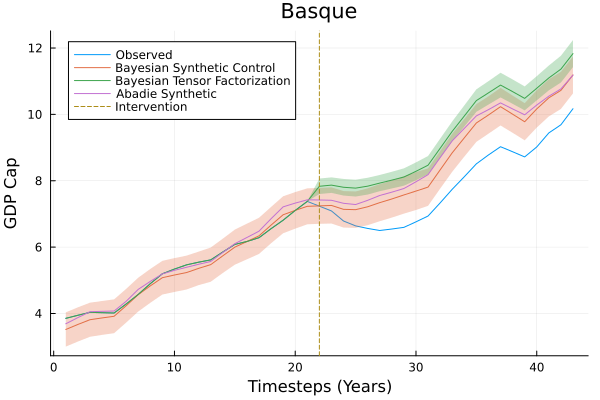

"C:\\Users\\nihar\\OneDrive\\Documents\\GitHub\\AppliedCausality\\Basque.png"

In [11]:
plot(Y, label="Observed")

plot!(predY, ribbon=errUpSynth - errDownSynth, fillalpha=.3, label="Bayesian Synthetic Control")
plot!(tensorPred, ribbon=errUpTensor - errDownTensor, fillalpha=.3, label="Bayesian Tensor Factorization")
plot!(s.ŷ₁, label="Abadie Synthetic")

plot!([22], label="Intervention", seriestype = :vline, line=:dash)
display(title!("Basque", xlabel="Timesteps (Years)", ylabel="GDP Cap"))
savefig("Basque.png")

## Germany

In [12]:
# Germany is region 7 and the intervention happened in 1990 or timestep 30
df = load_germany()

A = 2
I = 18
T = 44

YObs = zeros(A, I, T)
X = zeros(I-1, T)
Y = zeros(T)

for i ∈ eachrow(df)
    if i["index"] == 12
        i["index"] = 11
    end
    if i["index"] == 14
        i["index"] = 12
    end
    if i["index"] == 16
        i["index"] = 13
    end
    if i["index"] == 18
        i["index"] = 14
    end
    if i["index"] == 19
        i["index"] = 15
    end
    if i["index"] == 20
        i["index"] = 16
    end
    if i["index"] == 21
        i["index"] = 17
    end
    if i["index"] == 7 && i["year"] > 1989
        YObs[2, i["index"], i["year"]-1960+1] = i["gdp"]
    else
        YObs[1, i["index"], i["year"]-1960+1] = i["gdp"]
    end
    if i["index"] == 7
        Y[i["year"]-1960+1] = i["gdp"]
    elseif i["index"] < 7
        X[i["index"], i["year"]-1960+1] = i["gdp"]
    elseif i["index"] > 7
        X[i["index"]-1, i["year"]-1960+1] = i["gdp"]
    end
end

mask = Set{Tuple{Int64, Int64, Int64}}()

for a ∈ 1:A
    for i ∈ 1:I
        for t ∈ 1:T
            if YObs[a,i,t] == 0.0
                push!(mask, (a, i, t))
            end
        end
    end
end

In [13]:
numItr = 10000

α = 1.0/(I-1.0) .* ones(I-1)
θ = 1.0
β = 1.0

synth = initGibbs(I-1, obsT, θ, β, α)

samplePrior!(synth)
synth.Y = deepcopy(Y[1:obsT])
synth.X = deepcopy(X[:, 1:obsT])

sampleC = zeros(numItr)
sampleD = zeros(numItr, I-1)
Ysamples = zeros(numItr, T)

@showprogress for i ∈ 1:numItr
    updateGibbs!(synth)
end

thin = 1#50

@showprogress for i ∈ 1:numItr*thin
    updateGibbs!(synth)
    if i % thin == 0
        sampleC[div(i,thin)] = deepcopy(synth.C)
        sampleD[div(i,thin), :] = deepcopy(synth.D)
        Ysamples[div(i,thin), :] = sampleY(synth, X, T)
    end
end

predY = mean(Ysamples, dims=1)'
errUp = zeros(T)
errDown = zeros(T)
for t ∈ 1:T
    errUp[t] = quantile(Ysamples[:, t], 0.75)
    errDown[t] =  quantile(Ysamples[:, t], 0.25)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [14]:
numItr = 10000
K = 1
σ = 1.0

tensorFac = initGibbs(A, I, T, K, σ, σ, σ, σ)

samplePrior!(tensorFac)
tensorFac.Y = deepcopy(YObs)

Ysamples = zeros(numItr, A, I, T)

@showprogress for i ∈ 1:numItr
    updateGibbs!(tensorFac, mask)
end

@showprogress for i ∈ 1:numItr
    updateGibbs!(tensorFac, mask)
    Ysamples[i, :, :, :] = deepcopy(tensorFac.Y)
end


tensorPred = mean(Ysamples[:, 1, 7, :], dims=1)'
errUpTensor = zeros(T)
errDownTensor = zeros(T)
for t ∈ 1:T
    errUpTensor[t] = quantile(Ysamples[:, 1, 7, t], 0.75)
    errDownTensor[t] = quantile(Ysamples[:, 1, 7, t], 0.25)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:30
Progress: 100%|█████████████████████████████████████████| Time: 0:00:26


In [15]:
panel = load_germany_panel()
s = SimpleSCM(panel)
SynthControl.fit!(s)

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches C:\Users\nihar\.julia\packages\LineSearches\G1LRk\src\hagerzhang.jl:148



Synthetic Control Model

Treatment panel:
	Model is fitted
	Impact estimates: [351.759, 769.549, 585.335, -166.047, -630.087, -784.339, -1012.161, -1626.912, -1803.083, -2083.991, -2657.6, -2900.057, -3064.183, -3532.909]


Balanced Panel - single treated unit, continuous treatment
    Treated unit: West Germany
    Number of untreated units: 16
    First treatment period: 1990
    Number of pretreatment periods: 30
    Number of treatment periods: 14


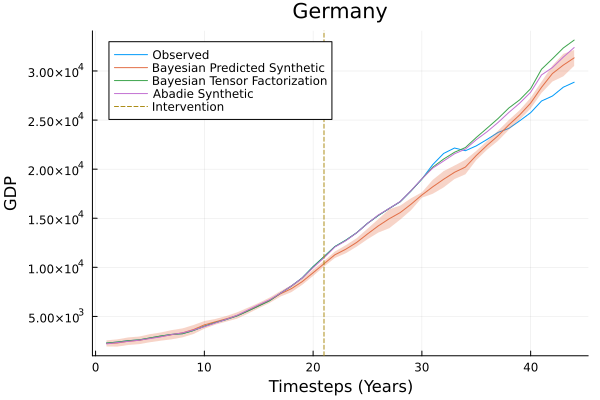

"C:\\Users\\nihar\\OneDrive\\Documents\\GitHub\\AppliedCausality\\Germany.png"

In [16]:
plot(Y, label="Observed")
plot!(predY, ribbon=errUp - errDown, fillalpha=.3, label="Bayesian Predicted Synthetic")
plot!(tensorPred, ribbon=errUpTensor - errDownTensor, fillalpha=.3, label="Bayesian Tensor Factorization")

plot!(s.ŷ₁, label="Abadie Synthetic")
plot!([ObsT], label="Intervention", seriestype = :vline, line=:dash)
display(title!("Germany", xlabel="Timesteps (Years)", ylabel="GDP"))
savefig("Germany.png")

## Brexit

In [17]:
#Standard Brexit Synthetic Control, Intervention happeed at timestep 31, Britain is country 22
df = load_brexit()

I = 23
T = 39
ObsT = 30

X = zeros(I-1, T)
Y = zeros(T)

YObs = zeros(A, I, T)

IMap = unique(df[!, "country"])
TMap = unique(df[!, "quarter"])

for i ∈ eachrow(df)
    state = findfirst(==(i["country"]), IMap)
    time = findfirst(==(i["quarter"]), TMap)
    if state == 22 && time > 30
        YObs[2, state, time] = i["realgdp"]
    else
        YObs[1, state, time] = i["realgdp"]
    end
end

mask = Set{Tuple{Int64, Int64, Int64}}()

for a ∈ 1:A
    for i ∈ 1:I
        for t ∈ 1:T
            if YObs[a,i,t] == 0.0
                push!(mask, (a, i, t))
            end
        end
    end
end

for i ∈ eachrow(df)
    state = findfirst(==(i["country"]), IMap)
    time = findfirst(==(i["quarter"]), TMap)
    if state == 22
        Y[time] = i["realgdp"]
    elseif state < 22
        X[state, time] = i["realgdp"]
    elseif state > 22
        X[state-1, time] = i["realgdp"]
    end
end


In [18]:
numItr = 10000

α = 1.0/(I-1.0) .* ones(I-1)
θ = 1.0
β = 1.0

synth = initGibbs(I-1, obsT, θ, β, α)

samplePrior!(synth)
synth.Y = deepcopy(Y[1:obsT])
synth.X = deepcopy(X[:, 1:obsT])

sampleC = zeros(numItr)
sampleD = zeros(numItr, I-1)
Ysamples = zeros(numItr, T)

@showprogress for i ∈ 1:numItr
    updateGibbs!(synth)
end

thin = 1#50

@showprogress for i ∈ 1:numItr*thin
    updateGibbs!(synth)
    if i % thin == 0
        sampleC[div(i,thin)] = deepcopy(synth.C)
        sampleD[div(i,thin), :] = deepcopy(synth.D)
        Ysamples[div(i,thin), :] = sampleY(synth, X, T)
    end
end

predY = mean(Ysamples, dims=1)'
errUp = zeros(T)
errDown = zeros(T)
for t ∈ 1:T
    errUp[t] = quantile(Ysamples[:, t], 0.75)
    errDown[t] =  quantile(Ysamples[:, t], 0.25)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [19]:
numItr = 10000
K = 1
σ = 1.0

tensorFac = initGibbs(A, I, T, K, σ, σ, σ, σ)

samplePrior!(tensorFac)
tensorFac.Y = deepcopy(YObs)

Ysamples = zeros(numItr, A, I, T)

@showprogress for i ∈ 1:numItr
    updateGibbs!(tensorFac, mask)
end

@showprogress for i ∈ 1:numItr
    updateGibbs!(tensorFac, mask)
    Ysamples[i, :, :, :] = deepcopy(tensorFac.Y)
end


tensorPred = mean(Ysamples[:, 1, 22, :], dims=1)'
errUpTensor = zeros(T)
errDownTensor = zeros(T)
for t ∈ 1:T
    errUpTensor[t] = quantile(Ysamples[:, 1, 22, t], 0.75)
    errDownTensor[t] = quantile(Ysamples[:, 1, 22, t], 0.25)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:29
Progress: 100%|█████████████████████████████████████████| Time: 0:00:26


In [20]:
panel = load_brexit_panel()
s = SimpleSCM(panel)
SynthControl.fit!(s)


Synthetic Control Model

Treatment panel:
	Model is fitted
	Impact estimates: [-0.54, -0.31, -0.206, -0.732, -1.241, -1.482, -1.818, -2.327, -1.994]


Balanced Panel - single treated unit, continuous treatment
    Treated unit: United Kingdom
    Number of untreated units: 22
    First treatment period: 2016-07-01
    Number of pretreatment periods: 30
    Number of treatment periods: 9


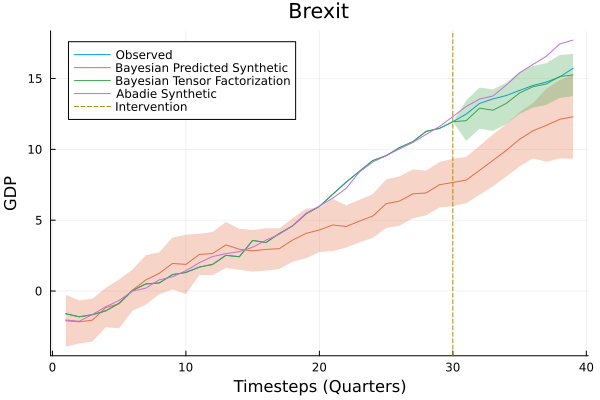

"C:\\Users\\nihar\\OneDrive\\Documents\\GitHub\\AppliedCausality\\Brexit.png"

In [30]:
plot(Y, label="Observed")
plot!(predY, ribbon=errUp - errDown, fillalpha=.3, label="Bayesian Predicted Synthetic")
plot!(tensorPred, ribbon=errUpTensor - errDownTensor, fillalpha=.3, label="Bayesian Tensor Factorization")

plot!(s.ŷ₁, label="Abadie Synthetic")
plot!([ObsT], label="Intervention", seriestype = :vline, line=:dash)
display(title!("Brexit", xlabel="Timesteps (Quarters)", ylabel="GDP"))
savefig("Brexit.png")

In [29]:
unique(df[!, "quarter"])

39-element Vector{Date}:
 2009-01-01
 2009-04-01
 2009-07-01
 2009-10-01
 2010-01-01
 2010-04-01
 2010-07-01
 2010-10-01
 2011-01-01
 2011-04-01
 2011-07-01
 2011-10-01
 2012-01-01
 ⋮
 2015-10-01
 2016-01-01
 2016-04-01
 2016-07-01
 2016-10-01
 2017-01-01
 2017-04-01
 2017-07-01
 2017-10-01
 2018-01-01
 2018-04-01
 2018-07-01

In [28]:
df

Row,country,quarter,realgdp
,String,Date,Float64
1,Australia,2009-01-01,1.04
2,Austria,2009-01-01,-1.53
3,Belgium,2009-01-01,-1.15
4,Canada,2009-01-01,-2.28
5,Denmark,2009-01-01,-1.42
6,Finland,2009-01-01,-6.8
7,France,2009-01-01,-1.67
8,Germany,2009-01-01,-4.49
9,Greece,2009-01-01,-4.74
